# ALTEGRAD Kaggle challenge

# I) Imports

In [2]:
# !nvidia-smi

In [2]:
# Go back to root folder
%cd ..
%pwd

/users/eleves-b/2020/thomas.li/MVA/ALTEGRAD/kaggle_challenge


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


'/users/eleves-b/2020/thomas.li/MVA/ALTEGRAD/kaggle_challenge'

In [3]:
# Install packages
# !pip install wandb onnx -Uq

# Imports
import os
import time
import numpy as np
import matplotlib.pyplot as pyplot
import seaborn as sns

sns.set_theme()

import pandas as pd
from tqdm import tqdm
import torch
from torch import optim
import torch.nn as nn
from torch_geometric.data import DataLoader
from torch.utils.data import DataLoader as TorchDataLoader
from transformers import AutoTokenizer

# Imports from custom package
from original_src.dataloader import GraphTextDataset, GraphDataset, TextDataset

from original_src.Model import Model

# from original_src.Model3 import Model

# from original_src.Model2 import Model

# Device configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# WandB Login and Setup
import wandb

wandb.login()
PROJECT_NAME = "ALTEGRAD_kaggle"  # TODO

cuda:0


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Network error (ConnectionError), entering retry loop.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


In [4]:
os.environ["WANDB_MODE"] = "offline"

In [5]:
run = wandb.init()

wandb: Network error (ConnectionError), entering retry loop.


Problem at: /tmp/ipykernel_810088/358236993.py 1 <module>


CommError: Run initialization has timed out after 90.0 sec. 
Please refer to the documentation for additional information: https://docs.wandb.ai/guides/track/tracking-faq#initstarterror-error-communicating-with-wandb-process-

#### Debugging

Vizulize text

In [11]:
from transformers import AutoTokenizer

# Load the AutoTokenizer with distilbert-base-uncased
distilbert_tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
scibert_tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")

# Input sentences
sentences = [
    "Xanthurenate is a quinolinemonocarboxylate that is the conjugate base of xanthurenic acid, obtained by deprotonation of the carboxy group. It has a role as an animal metabolite. It is a conjugate base of a xanthurenic acid.",
    "5,10-(methanylylidene)tetrahydromethanopterin(2-) is a doubly-charged organophosphate oxoanion arising from deprotonation of the carboxy and phosphate OH groups of the cationic species 5,10-(methanylylidene)tetrahydromethanopterin; major species at pH 7.3. It is an organophosphate oxoanion and a dicarboxylic acid dianion. It is a conjugate base of a 5,10-(methanylylidene)tetrahydromethanopterin.",
    "Alpha-L-Fucp-(1->4)-[beta-D-Galp3S-(1->3)]-beta-D-GlcpNAc is a branched amino trisaccharide consisting of N-acetylglucosamine having a fucosyl residue attached at the 4-position via an alpha-linkage and a 3-sulfated galactosyl residue attached at the 3-position via a beta-linkage. It has a role as an epitope. It is an amino trisaccharide and an oligosaccharide sulfate.",
]

# Tokenize each sentence
for sentence in sentences:
    # Print the original sentence and the tokenized output
    print(f"Original Sentence: {sentence}")

    tokens = distilbert_tokenizer(sentence, return_tensors="pt")
    input_ids = tokens["input_ids"]
    tokens_list = distilbert_tokenizer.convert_ids_to_tokens(input_ids[0].tolist())
    print(f"distilbert Tokenized Output: {tokens_list}")

    tokens = scibert_tokenizer(sentence, return_tensors="pt")
    input_ids = tokens["input_ids"]
    tokens_list = scibert_tokenizer.convert_ids_to_tokens(input_ids[0].tolist())
    print(f"scibert Tokenized Output: {tokens_list}")
    print()

Original Sentence: Xanthurenate is a quinolinemonocarboxylate that is the conjugate base of xanthurenic acid, obtained by deprotonation of the carboxy group. It has a role as an animal metabolite. It is a conjugate base of a xanthurenic acid.
distilbert Tokenized Output: ['[CLS]', 'x', '##ant', '##hur', '##ena', '##te', 'is', 'a', 'qui', '##no', '##line', '##mon', '##oca', '##rb', '##ox', '##yla', '##te', 'that', 'is', 'the', 'con', '##ju', '##gate', 'base', 'of', 'x', '##ant', '##hur', '##eni', '##c', 'acid', ',', 'obtained', 'by', 'de', '##pro', '##ton', '##ation', 'of', 'the', 'car', '##box', '##y', 'group', '.', 'it', 'has', 'a', 'role', 'as', 'an', 'animal', 'meta', '##bol', '##ite', '.', 'it', 'is', 'a', 'con', '##ju', '##gate', 'base', 'of', 'a', 'x', '##ant', '##hur', '##eni', '##c', 'acid', '.', '[SEP]']
scibert Tokenized Output: ['[CLS]', 'xanth', '##uren', '##ate', 'is', 'a', 'quin', '##oline', '##mon', '##ocar', '##box', '##ylate', 'that', 'is', 'the', 'conjugate', 'base', 

In [27]:
model, train_loader, val_loader, criterion, optimizer = make(config_instance)

/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 16, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


device : cuda


In [28]:
example_ct = 0
for batch in tqdm(train_loader):
    input_ids = batch.input_ids
    batch_example_ct = batch.input_ids.shape[0]
    batch.pop("input_ids")
    attention_mask = batch.attention_mask
    batch.pop("attention_mask")
    graph_batch = batch
    example_ct += batch_example_ct

 29%|██▉       | 241/826 [00:06<00:11, 50.63it/s]/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [2188], which does not match the required output shape [2, 2188]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)
 36%|███▋      | 301/826 [00:07<00:11, 47.66it/s]/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [1982], which does not match the required output shape [2, 1982]. This behavior is deprecated, and in a future PyTorch release 

In [63]:
batch = next(iter(train_loader))

In [27]:
input_ids = batch.input_ids
batch_example_ct = batch.input_ids.shape[0]
batch.pop("input_ids")
attention_mask = batch.attention_mask
batch.pop("attention_mask")
graph_batch = batch

In [28]:
edge_index = torch.tensor(graph_batch.edge_index[:, :1000], dtype=torch.long)

/tmp/ipykernel_1299938/2286432983.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(graph_batch.edge_index[:,:1000], dtype=torch.long)


Vizualize graph

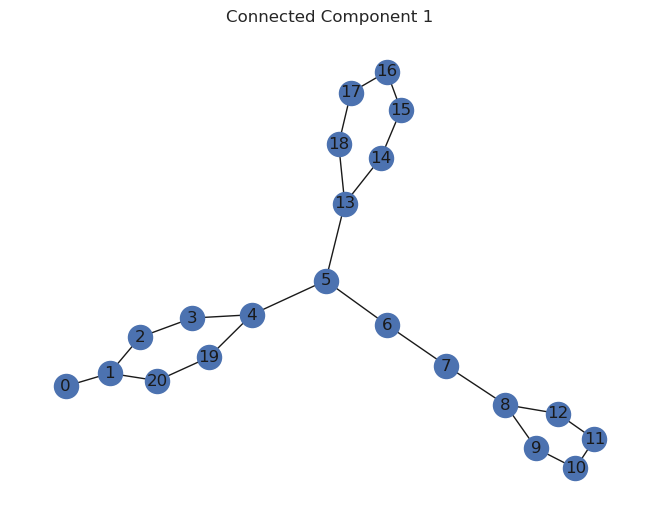

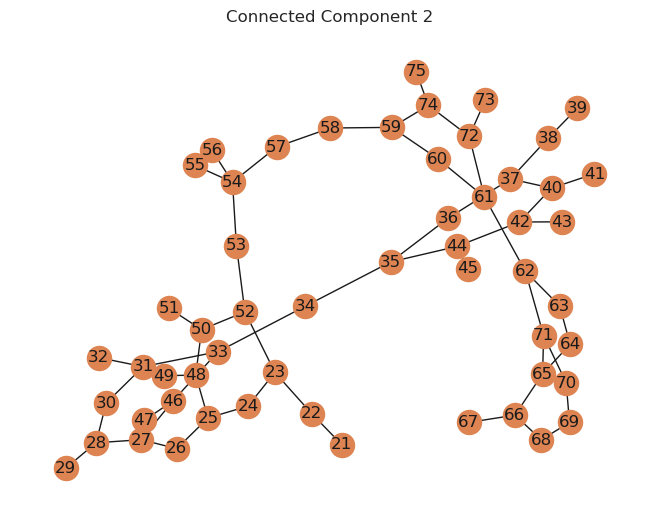

In [38]:
import networkx as nx
import torch_geometric
import matplotlib.pyplot as plt

data = torch_geometric.data.Data(edge_index=edge_index)
G = torch_geometric.utils.to_networkx(data, to_undirected=True)
# Get the connected components
connected_components = list(nx.connected_components(G))

# Plot each connected component separately
for i, component in enumerate(connected_components[:2]):
    subgraph = G.subgraph(component)

    # Draw the subgraph
    plt.figure()
    pos = nx.spring_layout(subgraph)
    nx.draw(subgraph, pos, with_labels=True, node_color=f"C{i}", cmap=plt.cm.rainbow)

    plt.title(f"Connected Component {i + 1}")

plt.show()

# VI) Run experiments

In [5]:
from src.pipeline import model_pipeline
from src.Model import Model
import torch

In [6]:
# Imports
from src.pipeline import model_pipeline
from src.Model import Model
import torch

# Config
config = dict(
    model_name="distilbert-base-uncased",
    batch_size=32,
    graph_learning_rate=1e-4,
    text_learning_rate=3e-5,
    learning_rate=1e-4,
    epochs=10,
    criterion="negative_sampling_contrastive_loss",
    similarity_fn="cosine_similarity",
    layer_norm=True,
    train_val=True,
    turbo=True,
)

# Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device :", device)

model = Model(
    model_name=config["model_name"],
    num_node_features=300,
    nout=768,
    nhid=300,
    graph_hidden_channels=300,
)
model.to(device)

# Run Name
run_name = "turbo test"

# Run code
model_pipeline(config, model, run_name=run_name)

device : cuda
{'model_name': 'distilbert-base-uncased', 'batch_size': 32, 'graph_learning_rate': 0.0001, 'text_learning_rate': 3e-05, 'learning_rate': 0.0001, 'epochs': 10, 'criterion': 'negative_sampling_contrastive_loss', 'similarity_fn': 'cosine_similarity', 'layer_norm': True, 'train_val': True, 'turbo': True}
run_name :  turbo test_02012223


Making dataloaders and loading model


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Start training


  0%|          | 0/10 [00:00<?, ?it/s]

train_loss after 01568 examples: 0.00491


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [2126], which does not match the required output shape [2, 2126]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)
/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [1678], which does not match the required output shape [2, 1678]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor

train_loss after 03168 examples: 0.00434


train_loss after 04768 examples: 0.00423


train_loss after 06368 examples: 0.00374


train_loss after 07968 examples: 0.00330


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [1578], which does not match the required output shape [2, 1578]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 09568 examples: 0.00308


train_loss after 11168 examples: 0.00282


train_loss after 12768 examples: 0.00268


train_loss after 14368 examples: 0.00254


train_loss after 15968 examples: 0.00244


train_loss after 17568 examples: 0.00227


train_loss after 19168 examples: 0.00233


train_loss after 20768 examples: 0.00220


train_loss after 22368 examples: 0.00207


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [2020], which does not match the required output shape [2, 2020]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 23968 examples: 0.00189


train_loss after 25568 examples: 0.00191


train_loss after 27168 examples: 0.00182


train_loss after 28768 examples: 0.00177


 10%|█         | 1/10 [08:36<1:17:25, 516.19s/it]

train_loss after 30349 examples: 0.00170


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [1992], which does not match the required output shape [2, 1992]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 31949 examples: 0.00157


train_loss after 33549 examples: 0.00153


train_loss after 35149 examples: 0.00158


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [2070], which does not match the required output shape [2, 2070]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 36749 examples: 0.00147


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [1670], which does not match the required output shape [2, 1670]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 38349 examples: 0.00143


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [2020], which does not match the required output shape [2, 2020]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 39949 examples: 0.00147


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [2986], which does not match the required output shape [2, 2986]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 41549 examples: 0.00137


train_loss after 43149 examples: 0.00137


train_loss after 44749 examples: 0.00127


train_loss after 46349 examples: 0.00128


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [1878], which does not match the required output shape [2, 1878]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 47949 examples: 0.00125


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [1618], which does not match the required output shape [2, 1618]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 49549 examples: 0.00130


train_loss after 51149 examples: 0.00131


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [2050], which does not match the required output shape [2, 2050]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 52749 examples: 0.00122


train_loss after 54349 examples: 0.00119


train_loss after 55949 examples: 0.00119


train_loss after 57549 examples: 0.00113


train_loss after 59149 examples: 0.00113


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [1922], which does not match the required output shape [2, 1922]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)
/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [2114], which does not match the required output shape [2, 2114]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor

train_loss after 60730 examples: 0.00102


train_loss after 62330 examples: 0.00096


train_loss after 63930 examples: 0.00091


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [2262], which does not match the required output shape [2, 2262]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 65530 examples: 0.00097


train_loss after 67130 examples: 0.00093


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [1818], which does not match the required output shape [2, 1818]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 68730 examples: 0.00096


train_loss after 70330 examples: 0.00090


train_loss after 71930 examples: 0.00097


train_loss after 73530 examples: 0.00090


train_loss after 75130 examples: 0.00089


train_loss after 76730 examples: 0.00088


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [2236], which does not match the required output shape [2, 2236]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 78330 examples: 0.00089


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [1988], which does not match the required output shape [2, 1988]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 79930 examples: 0.00091


train_loss after 81530 examples: 0.00095


train_loss after 83130 examples: 0.00095


train_loss after 84730 examples: 0.00079


train_loss after 86330 examples: 0.00079


train_loss after 87930 examples: 0.00085


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [1936], which does not match the required output shape [2, 1936]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)
 30%|███       | 3/10 [25:00<57:19, 491.30s/it]  

train_loss after 89511 examples: 0.00079


train_loss after 91111 examples: 0.00079


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [2040], which does not match the required output shape [2, 2040]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 92711 examples: 0.00074


train_loss after 94311 examples: 0.00069


train_loss after 95911 examples: 0.00066


train_loss after 97511 examples: 0.00069


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [1530], which does not match the required output shape [2, 1530]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 99111 examples: 0.00074


train_loss after 100711 examples: 0.00084


train_loss after 102311 examples: 0.00074


train_loss after 103911 examples: 0.00067


train_loss after 105511 examples: 0.00064


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [2182], which does not match the required output shape [2, 2182]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 107111 examples: 0.00071


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [2024], which does not match the required output shape [2, 2024]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 108711 examples: 0.00073


train_loss after 110311 examples: 0.00074


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [2502], which does not match the required output shape [2, 2502]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 111911 examples: 0.00070


train_loss after 113511 examples: 0.00060


train_loss after 115111 examples: 0.00060


train_loss after 116711 examples: 0.00071


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [1850], which does not match the required output shape [2, 1850]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 118311 examples: 0.00071


 40%|████      | 4/10 [31:08<44:15, 442.63s/it]/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [2232], which does not match the required output shape [2, 2232]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)
 40%|████      | 4/10 [31:18<46:58, 469.71s/it]
Traceback (most recent call last):
  File "/users/eleves-b/2020/thomas.li/MVA/ALTEGRAD/kaggle_challenge/src/pipeline.py", line 37, in model_pipeline
    train(
  File "/users/eleves-b/2020/thomas.li/MVA/ALTEGRAD/kaggle_challenge/src/train.py", line 41, in train
    current_loss, batch_example_ct = train_batch(
 

KeyboardInterrupt: 